# DA-DAN Modulation Analysis Project

### Set-Up

In [119]:
### imports
import navis
import fafbseg
import flybrains

import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from tqdm import tqdm
from functools import reduce
from tabulate import tabulate
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.gridspec as gridspec
import hvplot.pandas
from bokeh.plotting import figure, show, output_notebook

import ipywidgets

import scipy
import networkx as nx

import IProgress

import pyroglancer
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

from neuprint import fetch_synapses, NeuronCriteria as NC, SynapseCriteria as SC

from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import re

import gspread

In [120]:
import warnings
from pandas.errors import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [121]:
"""
label_fontsize = 16 
title_fontsize = 18

figwidth_size = 5
figheigth_size = 5

#navis display options for frontal view..
elev = -180
azim = -90
dist = 6
"""

'\nlabel_fontsize = 16 \ntitle_fontsize = 18\n\nfigwidth_size = 5\nfigheigth_size = 5\n\n#navis display options for frontal view..\nelev = -180\nazim = -90\ndist = 6\n'

In [122]:
print('navis version :',navis.__version__)
print('fafbseg version :',fafbseg.__version__)
print('flybrains version :',flybrains.__version__)
print('pyroglancer version :',pyroglancer.__version__)


navis version : 1.5.0
fafbseg version : 3.0.0
flybrains version : 0.2.9
pyroglancer version : 0.0.5


### Fetch data from Neuprint

In [123]:
## setting up Neuprint Client
## using dotenv to import Janelia PAT
from dotenv import load_dotenv
import os
load_dotenv()

## fetching Janelia client
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1', token=os.environ.get("JANELIA_PAT"))
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

In [124]:
### print roi hierarchy
rois = neu.fetch_roi_hierarchy(False,True,'text')
print(rois)

hemibrain
 +-- AL(L)*
 +-- AL(R)*
 +-- AOT(R)
 +-- CX
 |   +-- AB(L)*
 |   +-- AB(R)*
 |   +-- EB*
 |   +-- FB*
 |   +-- NO*
 |   +-- PB*
 +-- GC
 +-- GF(R)
 +-- GNG*
 +-- INP
 |   +-- ATL(L)*
 |   +-- ATL(R)*
 |   +-- CRE(L)*
 |   +-- CRE(R)*
 |   +-- IB*
 |   +-- ICL(L)*
 |   +-- ICL(R)*
 |   +-- SCL(L)*
 |   +-- SCL(R)*
 +-- LH(R)*
 +-- LX(L)
 |   +-- BU(L)*
 |   +-- LAL(L)*
 +-- LX(R)
 |   +-- BU(R)*
 |   +-- LAL(R)*
 +-- MB(+ACA)(R)
 |   +-- MB(R)
 |   |   +-- CA(R)*
 |   |   +-- PED(R)*
 |   |   +-- a'L(R)*
 |   |   +-- aL(R)*
 |   |   +-- b'L(R)*
 |   |   +-- bL(R)*
 |   |   +-- gL(R)*
 |   +-- dACA(R)
 |   +-- lACA(R)
 |   +-- vACA(R)
 +-- MB(L)
 |   +-- CA(L)*
 |   +-- a'L(L)*
 |   +-- aL(L)*
 |   +-- b'L(L)*
 |   +-- bL(L)*
 |   +-- gL(L)*
 +-- OL(R)
 |   +-- AME(R)*
 |   +-- LO(R)*
 |   +-- LOP(R)*
 |   +-- ME(R)*
 +-- PENP
 |   +-- CAN(R)*
 |   +-- FLA(R)*
 |   +-- PRW*
 |   +-- SAD*
 +-- POC
 +-- SNP(L)
 |   +-- SIP(L)*
 |   +-- SMP(L)*
 +-- SNP(R)
 |   +-- SIP(R)*
 |   +-

## Analysis

#### Get PAM neurons from hemibrains and fetch their connections

In [125]:
## fetch all neurons containing "PAM" from hemibrain dataset
pamneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^PAM.*",regex=True)) 

In [126]:
### print unique PAM types
uniquePAMTypes = pamneurons_df.type.unique()
print(uniquePAMTypes)

['PAM09' 'PAM10' 'PAM04_a' 'PAM04_b' 'PAM01_b' 'PAM11' 'PAM01_a' 'PAM05'
 'PAM08_c' 'PAM08_e' 'PAM02' 'PAM06_b' 'PAM14' 'PAM13' 'PAM06_a' 'PAM08_b'
 'PAM12' 'PAM03' 'PAM08_a' 'PAM07' 'PAM08_d' 'PAM15_a' 'PAM15_b']


In [127]:
## function that retrieves specified connections via neuprint

def getFilteredConnections(typeA="^PAM.*", typeB="^PAM.*", minWeight=1, silent=True):
    """
    Retrieves connections between neurons of specified types with a minimum synaptic weight from the Neuprint database.

    Args:
        typeA (str): Regular expression pattern for the type of pre-synaptic neurons. Defaults to "^PAM.*".
        typeB (str): Regular expression pattern for the type of post-synaptic neurons. Defaults to "^PAM.*".
        minWeight (int): The minimum synaptic weight for connections to be retrieved. Defaults to 1.
        silent (bool): If False, the function will print the dataframes containing neuron and connection information. Defaults to True.

    Returns:
        pandas.DataFrame: A dataframe containing the filtered connections with a weight greater than or equal to minWeight.
    """
    neuron_df, conn_df = fetch_adjacencies(NC(status='Traced', type=typeA, regex=True), NC(status='Traced', type=typeB, regex=True))
    conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
    filteredConnections = conn_df[conn_df['weight'] >= minWeight]
    filteredConnections.sort_values('weight', ascending=False, inplace=True)
    if not silent:
        print(neuron_df)
        print(conn_df)

    return filteredConnections

In [141]:
### get PAM-PAM connections
filteredConnections = getFilteredConnections(silent=False)

  0%|          | 0/2 [00:00<?, ?it/s]

         bodyId     type          instance
0     268725517    PAM09    PAM09(B1ped)_L
1     298595394    PAM10       PAM10(B1)_R
2     299613480    PAM09    PAM09(B1ped)_R
3     328253133    PAM10       PAM10(B1)_R
4     328546871    PAM10       PAM10(B1)_R
..          ...      ...               ...
296  5813100896    PAM12       PAM12(y3)_R
297  5813109941    PAM07  PAM07(y4<y1y2)_R
298  5813124740    PAM07  PAM07(y4<y1y2)_L
299  5813127030  PAM06_a   PAM06_a(B'2m)_R
300  5901205545    PAM05     PAM05(B'2p)_L

[301 rows x 3 columns]
      bodyId_pre  bodyId_post     roi  weight type_pre    instance_pre  \
0      268725517    298595394   bL(R)       2    PAM09  PAM09(B1ped)_L   
1      268725517    298595394  b'L(R)       1    PAM09  PAM09(B1ped)_L   
2      268725517    298595394   bL(L)       1    PAM09  PAM09(B1ped)_L   
3      268725517    299613480   bL(R)       1    PAM09  PAM09(B1ped)_L   
4      268725517    328253133   bL(L)       1    PAM09  PAM09(B1ped)_L   
...          ...

In [129]:
### extract unique neuron instances from PAM PAM connections and prepare for dict
uniquePAMNeuronsPre = filteredConnections["instance_pre"].unique()
print(uniquePAMNeuronsPre)
uniquePAMNeuronsPost = filteredConnections["instance_post"].unique()
print("")
print(uniquePAMNeuronsPost)

# Parse the unique values into a string for a dict
possibleTargetsInstance = "{" + ",\n".join(f"'{neuron}': '{neuron}'" for neuron in sorted(set(uniquePAMNeuronsPre).union(uniquePAMNeuronsPost))) + "}"
print("\nPossible Targets Instance for dict:")
print(possibleTargetsInstance)


["PAM13(B'1ap)_L" 'PAM07(y4<y1y2)_L' 'PAM10(B1)_L' 'PAM08_c(y4)_L'
 'PAM10(B1)_R' 'PAM04_a(B2)_R' "PAM13(B'1ap)_R" "PAM06_b(B'2m)_L"
 'PAM11(a1)_R' 'PAM11(a1)_L' "PAM06_a(B'2m)_L" 'PAM08_b(y4)_L'
 'PAM04_a(B2)_L' "PAM05(B'2p)_R" 'PAM08_c(y4)_R' "PAM05(B'2p)_L"
 "PAM06_a(B'2m)_R" "PAM14(B'1m)_R" 'PAM09(B1ped)_R' 'PAM09(B1ped)_L'
 'PAM12(y3)_L' "PAM02(B'2a)_R" 'PAM08_a(y4)_L' 'PAM01_b(y5)_R'
 'PAM07(y4<y1y2)_R' 'PAM01_b(y5)_L' 'PAM08_d(y4)_R' 'PAM08_d(y4)_L'
 'PAM01_a(y5)_R' "PAM14(B'1m)_L" "PAM15_b(y5B'2a)_R" 'PAM08_e(y4)_R'
 'PAM08_e(y4)_L' "PAM02(B'2a)_L" "PAM06_b(B'2m)_R" 'PAM04_b(B2)(ADM02)_L'
 'PAM12(y3)_R' "PAM03(B2B'2a)_R" 'PAM08_b(y4)_R' 'PAM08_a(y4)_R'
 "PAM03(B2B'2a)_L" 'PAM01_a(y5)_L' "PAM15_a(y5B'2a)_R" "PAM15_b(y5B'2a)_L"
 "PAM15_a(y5B'2a)_L" 'PAM04_b(B2)_R']

["PAM13(B'1ap)_L" 'PAM08_c(y4)_L' 'PAM10(B1)_L' "PAM13(B'1ap)_R"
 'PAM07(y4<y1y2)_L' 'PAM04_a(B2)_L' 'PAM08_a(y4)_L' 'PAM10(B1)_R'
 'PAM09(B1ped)_R' "PAM06_b(B'2m)_L" 'PAM08_b(y4)_L' 'PAM11(a1)_R'
 "PAM06_a(B'2m)_L" "

#### Heatmap Visualization of PAM-PAM connections

In [130]:
#### visualize as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title).opts(xrotation=60)


:HeatMap   [columns,index]   (value)

In [131]:
### collapse PAM types and then show as matrix

PAMCollapsedConnections = filteredConnections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)

matrix = neu.connection_table_to_matrix(PAMCollapsedConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title = title+" -- PAM Types Collapsed").opts(xrotation=60)

:HeatMap   [columns,index]   (value)

In [132]:
### show unique neurons as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'instance', sort_by='instance',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title+" -- PAM neurons").opts(xrotation=60)


:HeatMap   [columns,index]   (value)

#### detailed connection analysis

In [137]:
#### functions to extract axons and dendrites of a specific neuron type, and extract unique connection partners

### extracts dendrites and axons for a specific PAM type and returns them as a dataframe
def extractDendritesPerType(target = "PAM05", targetMode = 'type', connections=filteredConnections):
    if targetMode == "type":
        target_pattern = target+r'\_?.?'
        regex=True
    if targetMode == "instance":
        target_pattern = target
        regex=False
    dendrites = connections[connections[targetMode+'_post'].str.contains(target_pattern, regex=regex)]
    #print(dendrites)
    return dendrites

### extracts dendrites and axons for a specific PAM type and returns them as a dataframe
def extractAxonsPerType(target = "PAM05", targetMode = 'type', connections=filteredConnections):
    if targetMode == "type":
        target_pattern = target+r'\_?.?'
        regex=True
    if targetMode == "instance":
        target_pattern = target
        regex=False
    axons = connections[connections[targetMode+'_pre'].str.contains(target_pattern, regex=regex)]
    #print(axons)
    return axons

## extracts dataframe of unique connection partners in a dataframe that has connections (e.g. dendrites or axons dataframe)
## takes type : 'pre' or 'post' and partnerType : 'instance' or 'type' or 'bodyId', 'typemerged' acts like type but merges PAM neuron subgroups (e.g. PAM04_a, PAM04_b -> PAM04)
def extractUniqueConnectionPartners(connections, type = "pre", partnerType = "instance",mergePAMSubtypes = False):
    if mergePAMSubtypes:
        connections = connections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)
    connectionpartners = connections[partnerType+'_'+type].unique()
    return connectionpartners

def listUniqueConnectionPartners(connections, type = "pre", printOut = True):
    typePartners = extractUniqueConnectionPartners(connections,type=type,partnerType="type",mergePAMSubtypes=True)
    subTypePartners = extractUniqueConnectionPartners(connections,type=type,partnerType="type")
    instancePartners = extractUniqueConnectionPartners(connections,type=type,partnerType="instance")
    bodyIdPartners = extractUniqueConnectionPartners(connections,type=type,partnerType="bodyId")
    if printOut: 
        print("Unique connection partners")
        print("by superType")
        print("['PAM']")
        print("by type")
        print(typePartners)
        print("by subType")
        print(subTypePartners)
        print("by instance")
        print(instancePartners)
        print("by bodyId")
        print(bodyIdPartners)
    return subTypePartners, instancePartners, bodyIdPartners

print("Printing unique connection partners of PAM04 neurons")
subTypePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(extractDendritesPerType("PAM16"))

Printing unique connection partners of PAM04 neurons
Unique connection partners
by superType
['PAM']
by type
[]
by subType
[]
by instance
[]
by bodyId
[]


In [134]:

## takes type : 'pre' or 'post' and partnerMode : 'instance' or 'type' or 'bodyId'
def collapseConnections(connections, type="pre", partnerMode="type",mergePAMSubtypes = False, mergePAMs = False, mergeOthers = True):
    """
    Collapses a connections dataframe by summing the weights of connections.

    Parameters:
    - connections (DataFrame): The dataframe containing synaptic connections.
    - type (str): Specifies the type of connections to consider; either 'pre' for presynaptic or 'post' for postsynaptic.
    - partnerMode (str): Specifies the partner type to consider; options are 'instance', 'type', or 'bodyId'.
    - mergePAMSubtypes (bool, optional): If True, merges PAM neuron subtypes (e.g., PAM04_a, PAM04_b -> PAM04).
    - mergePAMs (bool, optional): If True, merges all PAM neuron types into a single 'PAM' category.
    - mergeOthers (bool, optional): If True, merges other neuron types based on predefined patterns.

    Returns:
    - DataFrame: A dataframe with connections collapsed by the specified partnerMode and type, with a sum of the weights.
    """
    if mergePAMSubtypes:
        connections = connections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)
    if mergePAMs:
        print("PAM merging not working yet. Proceeding unmerged.") 
        #connections['type_' + type] = connections['type_' + type].replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM', regex=True)
    if mergeOthers:
        connections.loc[:, 'type_' + type] = connections['type_' + type].replace(to_replace=r'.*KC.*', value=r'KCs', regex=True)
        connections.loc[:, 'type_' + type] = connections['type_' + type].replace(to_replace=r'.*MBON.*', value=r'MBONs', regex=True)
    # Group the connections by the specified partnerMode and type, then sum the weights
    grouped = connections.groupby([partnerMode + '_' + type]).agg({'weight': 'sum'}).reset_index()
    # Rename the columns to reflect the collapsed data
    grouped.columns = [partnerMode + '_' + type, 'total_weight']
    return grouped.sort_values('total_weight', ascending=False)

### for each target in targets, this extracts weights of synaptic connections in each neuron type called 'target'
def extractUniquePartnerConnectionStrengthIterated(targets, targetMode='type', connections=filteredConnections,type="pre", partnerMode="type",connectionType = "dendrites", normalized = True, etc = True, etcTreshhold=0.03,mergePAMSubtypes=False, mergeOthers = True):
    connectionsTable = pd.DataFrame()
    for target in targets:
        targetConnections = extractUniquePartnerConnectionStrength(target, targetMode=targetMode, connections=connections, type=type, partnerMode=partnerMode,connectionType = connectionType, normalized = normalized, etc = etc, etcTreshhold=0.03, mergePAMSubtypes=mergePAMSubtypes, mergeOthers=mergeOthers)
        if connectionsTable.empty:
            connectionsTable = targetConnections
        else:
            connectionsTable = connectionsTable.merge(targetConnections, on=partnerMode+'_'+type, how='outer')
        connectionsTable = connectionsTable.fillna(0)
        connectionsTable = connectionsTable.set_index(partnerMode+'_'+type)
    
    if etc:
        threshold = etcTreshhold * connectionsTable.sum().sum()
        others = connectionsTable[connectionsTable.sum(axis=1) < threshold].sum()
        connectionsTable = connectionsTable[connectionsTable.sum(axis=1) >= threshold]
        connectionsTable.loc['others'] = others

    if normalized:
        connectionsTable = connectionsTable.div(connectionsTable.sum(axis=0), axis=1) * 100

    return connectionsTable

### extract weights of synaptic connections per types in the neuron type called 'target'
def extractUniquePartnerConnectionStrength(target, targetMode = 'type', connections=filteredConnections, type="pre", partnerMode="type",connectionType = "dendrites", normalized = True, etc = True, etcTreshhold=0.03, mergePAMSubtypes=False, mergePAMs = False, mergeOthers = True):
    if connectionType == "dendrites":
        conn = extractDendritesPerType(target,targetMode=targetMode, connections=connections)
    if connectionType == "axons":
        conn = extractAxonsPerType(target,targetMode=targetMode,connections=connections)
    targetConnections = collapseConnections(conn, type=type, partnerMode=partnerMode, mergePAMSubtypes = mergePAMSubtypes, mergePAMs = mergePAMs, mergeOthers = mergeOthers)
    targetConnections = targetConnections.rename(columns={'total_weight': target})
    return targetConnections

In [139]:
### functions for plotting synapse statistics

PAM_colors = {
    '.*PAM01.*': '#FF6F61',  # Living Coral
    '.*PAM02.*': '#6B5B95',  # Wisteria
    '.*PAM03.*': '#88B04B',  # Greenery
    '.*PAM04.*': '#F7CAC9',  # Rose Quartz
    '.*PAM05.*': '#92A8D1',  # Serenity
    '.*PAM06.*': '#964F4C',  # Marsala
    '.*PAM07.*': '#B565A7',  # Radiant Orchid
    '.*PAM08.*': '#009B77',  # Emerald
    '.*PAM09.*': '#DD4124',  # Flame
    '.*PAM10.*': '#45B8AC',  # Turquoise
    '.*PAM11.*': '#EFC050',  # Sunflower
    '.*PAM12.*': '#5B5EA6',  # Blue Bell
    '.*PAM13.*': '#9B2335',  # Red Dahlia
    '.*PAM14.*': '#DFCFBE',  # Almond Milk
    '.*PAM15.*': '#BC243C',  # Blue Atoll
    '.*other.*' : 'grey',  # Thistle
    '.*KC.*': '#55B4B0',     # Scarlet Red
    '.*MBON.*': '#C3447A',    # Pink Peacock
    '.*APL.*':'#FFD700',  # Gold
    '.*DPM.*':'#A52A2A',  # Brown
}

def visualizeSynapseConnectionTable(connectionTable, title="PAM-PAM Synapse Statistic", titleSuffix="", xLabel="None", yLabel='None', color_dict=PAM_colors, legend_title="", settingsSpec=None):
    """
    Visualizes a synapse connection table as a stacked bar chart.

    Parameters:
    - connectionTable: DataFrame containing the synapse connection data.
    - title: The title of the plot.
    - titleSuffix: Additional suffix to append to the plot title.
    - xLabel: The label for the x-axis.
    - yLabel: The label for the y-axis.
    - color_dict: Dictionary mapping synapse types to colors.
    - legend_title: The title for the legend.
    """
    connectionTable = connectionTable.T
    # Plot initialization
    fig, ax = plt.subplots(figsize=(6, 6))
    bar_width = 0.85  # Width of each bar

    # Iterative plotting
    for bar_index, (bar_name, row_values) in enumerate(connectionTable.iterrows()):
        bottom_height = 0  # Starting point for the first segment of each bar
        for segment_name, segment_value in row_values.sort_values(ascending=False).items():
            color = next((v for k, v in color_dict.items() if re.search(k, segment_name)), None)
            ax.bar(bar_index, segment_value, color=color, edgecolor='gray', linewidth=1, bottom=bottom_height, label=segment_name if bar_index == 0 else "", width=bar_width)
            bottom_height += segment_value  # Update the bottom for the next segment in this bar

    # Customizing the plot with labels, title, etc.
    ax.set_xticks(range(len(connectionTable)))
    ax.set_xticklabels(connectionTable.index)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(title + titleSuffix)
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, title=legend_title, loc='center left', bbox_to_anchor=(1, 0.5))
    # Fine-tuning appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if settingsSpec is not None:
        plt.figtext(0.5, 0.01, settingsSpec, wrap=True, horizontalalignment='center', fontsize=8, color='grey')
    plt.show()

def plotPAMStatistic(targets, targetMode = "type",etcTreshhold=0.03, partnerMode="type", connections=filteredConnections, normalized=True, title="PAM-PAM Connections Statistic", mergePAMSubtypes=False, mergePAMs=False, mergeOthers=True, yLabel="% of synaptic connections", color_dict=PAM_colors,settingsSpec=""):
    """
    Plots PAM synapse statistics for a given set of targets.

    Parameters:
    - targets: List of target neuron types to include in the analysis.
    - targetMode: Whether each bar should be graphed for 'type' or for 'instance' groups.
    - etcTreshhold: Threshold for including 'etc' category in the analysis.
    - partnerMode: The type of partner neuron to consider in the analysis.
    - connections: DataFrame containing the synapse connection data.
    - normalized: Boolean indicating whether to normalize the connection strengths.
    - title: The title of the plot.
    - mergePAMSubtypes: Boolean indicating whether to merge PAM subtypes.
    - mergePAMs: Boolean indicating whether to merge all PAMs.
    - mergeOthers: Boolean indicating whether to merge other neuron types.
    - yLabel: The label for the y-axis.
    - color_dict: Dictionary mapping synapse types to colors.
    """
    pamMerged = ""
    if mergePAMSubtypes:
        pamMerged = " (PAM subtypes merged)"
    if not normalized:
        yLabel = "Summed weight of synaptic connections"
    if mergePAMs:
        mergePAMSubtypes = False
    settingsSpec = settingsSpec+f"Target Mode: {targetMode}, Partner Mode: {partnerMode}, Threshold: {etcTreshhold:.4f},  {'Normalized' if normalized else 'Not Normalized'}, Merge PAM subtypes: {'Yes' if mergePAMSubtypes else 'No'}, Merge PAMs: {'Yes' if mergePAMs else 'No'}, Merge Others: {'Yes' if mergeOthers else 'No'}"
    # Extract dendrite connections for PAMs 01-06
    connectionType = "dendrites"
    type = "pre"
    visualizeSynapseConnectionTable(
        extractUniquePartnerConnectionStrengthIterated(targets, targetMode=targetMode,connections=connections, connectionType=connectionType, type=type, partnerMode=partnerMode, etcTreshhold=etcTreshhold, normalized=normalized, mergePAMSubtypes=mergePAMSubtypes, mergeOthers=mergeOthers),
        xLabel="PAM type", yLabel=yLabel, title=title, titleSuffix=" - dendritic inputs" + pamMerged, color_dict=color_dict, settingsSpec=settingsSpec)

    # Extract axon connections
    connectionType = "axons"
    type = "post"
    visualizeSynapseConnectionTable(
        extractUniquePartnerConnectionStrengthIterated(targets, targetMode=targetMode, connections=connections, connectionType=connectionType, type=type, partnerMode=partnerMode, etcTreshhold=etcTreshhold, normalized=normalized, mergePAMSubtypes=mergePAMSubtypes, mergeOthers=mergeOthers),
        xLabel="PAM type", yLabel=yLabel, title=title, titleSuffix=" - axonal outputs" + pamMerged, color_dict=color_dict,settingsSpec=settingsSpec)


def plotPAMStatistics(targets, connections, thresholdmodifier=1):
    """
    Plots PAM statistics for both type and instance, with an adjustable threshold modifier.

    Parameters:
    - targets: List of target neuron types to include in the analysis.
    - connections: DataFrame containing the synapse connection data.
    - thresholdmodifier: Modifier to adjust the threshold for including 'etc' category.
    """
    print("This method is deprecated, please use the widget to visualize PAm connection plots.")
    partnerMode = "type"  # instance, type, bodyId
    treshhold = 0.02 / thresholdmodifier
    plotPAMStatistic(connections=filteredConnections, targets=targets, etcTreshhold=treshhold, partnerMode=partnerMode, mergePAMSubtypes=True)
    partnerMode = "instance"  # instance, type, bodyId
    treshhold = 0.02 / thresholdmodifier
    plotPAMStatistic(connections=filteredConnections, targets=targets, etcTreshhold=treshhold, partnerMode=partnerMode, mergePAMSubtypes=True)
    # 
    partnerMode = "type"  # instance, type, bodyId
    treshhold = 0.015 / thresholdmodifier
    plotPAMStatistic(connections=connections, targets=targets, etcTreshhold=treshhold, partnerMode=partnerMode, normalized=False, mergePAMSubtypes=True, title="All PAM synapses statistic", mergePAMs=False)


In [136]:

targets = ["PAM01","PAM02","PAM03","PAM04"]
partnerType = "type" ## instance, type, bodyId
treshhold= 0.02
plotPAMStatistic(targets=targets,etcTreshhold=treshhold,partnerType=partnerType,mergePAMSubtypes=True,color_dict=PAM_colors)

TypeError: plotPAMStatistic() got an unexpected keyword argument 'partnerType'

In [ ]:
### retrieving all connections between PAM and non-PAM neurons
filteredPAMConnections = getFilteredConnections("^PAM.*","^.*", minWeight=1)
typePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(filteredPAMConnections,type="pre")
typePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(filteredPAMConnections,type="post")

  0%|          | 0/2 [00:00<?, ?it/s]

Unique connection partners
by superType
['PAM']
by type
['PAM10' 'PAM07' 'PAM11' 'PAM06' 'PAM05' 'PAM08' 'PAM01' 'PAM02' 'PAM04'
 'PAM09' 'PAM12' 'PAM14' 'PAM13' 'PAM15' 'PAM03']
by subType
['PAM10' 'PAM07' 'PAM11' 'PAM06_a' 'PAM05' 'PAM08_c' 'PAM08_a' 'PAM08_b'
 'PAM01_a' 'PAM02' 'PAM04_a' 'PAM06_b' 'PAM08_d' 'PAM09' 'PAM08_e' 'PAM12'
 'PAM14' 'PAM13' 'PAM01_b' 'PAM15_b' 'PAM15_a' 'PAM03' 'PAM04_b']
by instance
['PAM10(B1)_R' 'PAM10(B1)_L' 'PAM07(y4<y1y2)_L' 'PAM11(a1)_R'
 "PAM06_a(B'2m)_L" 'PAM11(a1)_L' "PAM06_a(B'2m)_R" "PAM05(B'2p)_L"
 "PAM05(B'2p)_R" 'PAM08_c(y4)_L' 'PAM08_a(y4)_R' 'PAM08_b(y4)_R'
 'PAM01_a(y5)_R' 'PAM07(y4<y1y2)_R' "PAM02(B'2a)_R" 'PAM04_a(B2)_R'
 'PAM08_c(y4)_R' "PAM06_b(B'2m)_L" 'PAM01_a(y5)_L' 'PAM08_a(y4)_L'
 'PAM04_a(B2)_L' 'PAM08_b(y4)_L' "PAM06_b(B'2m)_R" 'PAM08_d(y4)_R'
 'PAM09(B1ped)_R' "PAM02(B'2a)_L" 'PAM08_e(y4)_R' 'PAM12(y3)_R'
 'PAM09(B1ped)_L' 'PAM12(y3)_L' 'PAM08_e(y4)_L' "PAM14(B'1m)_R"
 "PAM13(B'1ap)_R" "PAM13(B'1ap)_L" 'PAM01_b(y5)_L' 'PAM08_d(

In [ ]:
##testing whether connections make sense
extractDendritesPerType(target="PAM05",connections=filteredPAMConnections)
extractAxonsPerType(target="PAM05",connections=filteredPAMConnections)

bodyId_pre  bodyId_post     roi  weight type_pre   instance_pre  \
69087  5813069965    487925063  b'L(L)      77    PAM05  PAM05(B'2p)_L   
8114    549610772    895441451  b'L(R)      75    PAM05  PAM05(B'2p)_R   
64514  5812983399    912951014  b'L(L)      74    PAM05  PAM05(B'2p)_L   
69138  5813069965    912951014  b'L(L)      70    PAM05  PAM05(B'2p)_L   
45788  1171690479    895441451  b'L(R)      66    PAM05  PAM05(B'2p)_R   
...           ...          ...     ...     ...      ...            ...   
13598   643523134   5813020288  b'L(L)       1    PAM05  PAM05(B'2p)_L   
13594   643523134   5812984045  b'L(R)       1    PAM05  PAM05(B'2p)_L   
13592   643523134   5812983869  b'L(R)       1    PAM05  PAM05(B'2p)_L   
13591   643523134   5812983646  b'L(R)       1    PAM05  PAM05(B'2p)_L   
13588   643523134   5812983510  SMP(L)       1    PAM05  PAM05(B'2p)_L   

        type_post              instance_post  
69087      MBON04  MBON04(B'2mp_bilateral)_R  
8114       MBON26             MBON26(B'2d)_R  
64514      MBON26      MBON26(B'2d)(PDM28)_L  
69138      MBON26      MBON26(B'2d)(PDM28)_L  
45788      MBON26             MBON26(B'2d)_R  
...           ...                        ...  
13598     PAM08_b              PAM08_b(y4)_L  
13594  KCa'b'-ap2               KCa'b'-ap2_R  
13592  KCa'b'-ap2               KCa'b'-ap2_R  
13591  KCa'b'-ap1               KCa'b'-ap1_R  
13588      CRE092            CRE092(PDM13)_L  

[3751 rows x 8 columns]

In [ ]:
### 
targets = ["PAM01","PAM02","PAM03","PAM04"]
partnerType = "type" ## instance, type, bodyId
treshhold= 0.02
#plotPAMStatistic(connections=filteredPAMConnections,targets=targets,etcTreshhold=treshhold,partnerMode=partnerType,normalized=False, mergePAMSubtypes = True, title="All PAM synapses statistic", mergePAMs = False)

#TODO FIX PAM MERGING IN collapseConnections ()

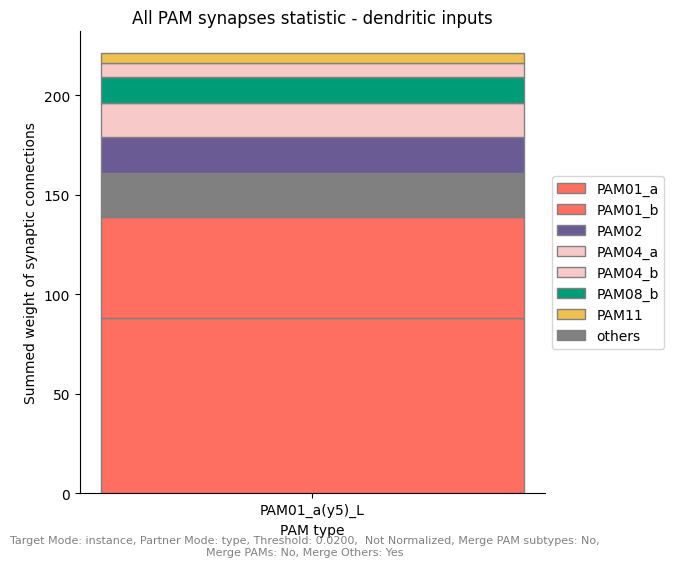

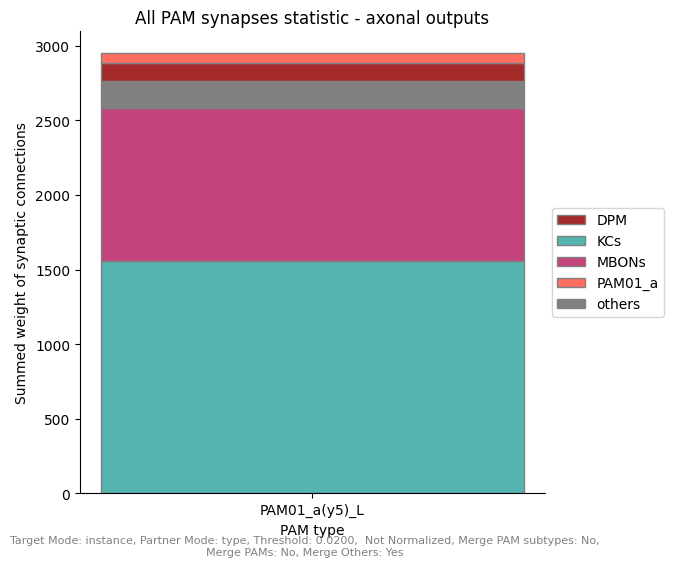

In [ ]:
### 
targets = ["PAM01_a(y5)_L"]
partnerType = "type" ## instance, type, bodyId

treshhold= 0.02
plotPAMStatistic(connections=filteredPAMConnections,targets=targets,targetMode="instance",etcTreshhold=treshhold,partnerMode=partnerType,normalized=False, mergePAMSubtypes = False, title="All PAM synapses statistic", mergePAMs = False)



In [ ]:
#plotPAMStatistics(["PAM01", "PAM02", "PAM03"],filteredPAMConnections,1.5)

### plotting widget

RadioButtons(description='Visualization Mode:', index=1, options=('PAM-PAM synapses', 'All PAM synapses'), val…

RadioButtons(description='Target Mode:', options=('type', 'instance'), value='type')

SelectMultiple(description='Targets', index=(4, 5, 6, 7), options=('PAM01', 'PAM02', 'PAM03', 'PAM04', 'PAM05'…

RadioButtons(description='Partner Type:', index=1, options=('type', 'instance'), value='instance')

Checkbox(value=False, description='Merge PAM types')

Checkbox(value=False, description='Normalized')

FloatText(value=0.0, description='Etc Threshhold:')

Button(description='Update Plot', icon='check', style=ButtonStyle(), tooltip='Click to update the plot with th…

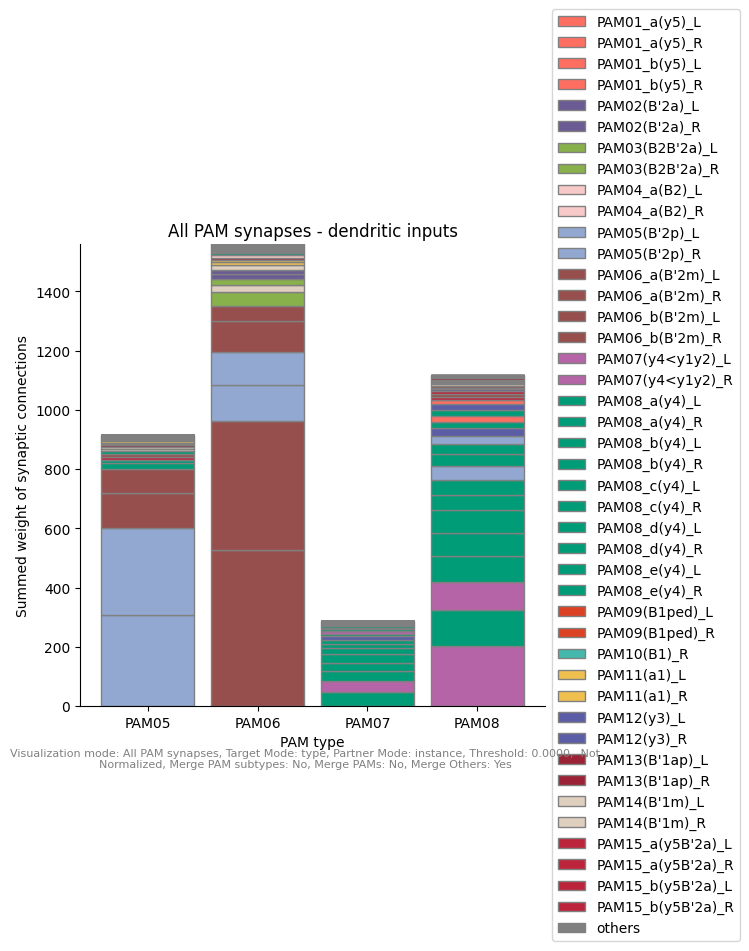

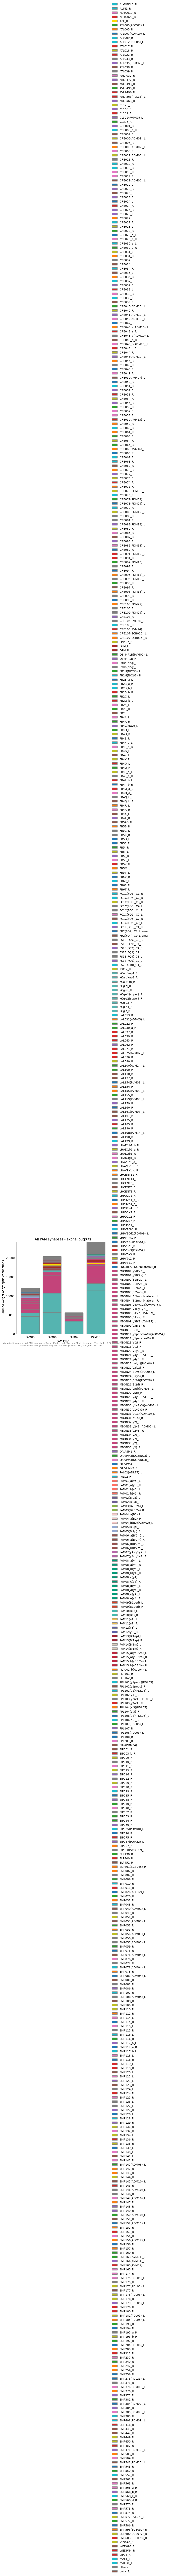

In [140]:

from IPython.display import clear_output
from ipywidgets import interact, widgets
import ipywidgets as widgets

# Define the possible targets by type
possibleTargetsType = {
    "PAM01": "PAM01",
    "PAM02": "PAM02",
    "PAM03": "PAM03",
    "PAM04": "PAM04",
    "PAM05": "PAM05",
    "PAM06": "PAM06",
    "PAM07": "PAM07",
    "PAM08": "PAM08",
    "PAM09": "PAM09",
    "PAM10": "PAM10",
    "PAM11": "PAM11",
    "PAM12": "PAM12",
    "PAM13": "PAM13",
    "PAM14": "PAM14",
    "PAM15": "PAM15",
}

# Define the possible targets by subtype
possibleTargetsSubtype = {
    "PAM01_a": "PAM01_a",
    "PAM01_b": "PAM01_b",
    "PAM02": "PAM02",
    "PAM03": "PAM03",
    "PAM04_a": "PAM04_a",
    "PAM04_b": "PAM04_b",
    "PAM05": "PAM05",
    "PAM06_a": "PAM06_a",
    "PAM06_b": "PAM06_b",
    "PAM07": "PAM07",
    "PAM08_a": "PAM08_a",
    "PAM08_b": "PAM08_b",
    "PAM08_c": "PAM08_c",
    "PAM08_d": "PAM08_d",
    "PAM08_e": "PAM08_e",
    "PAM09": "PAM09",
    "PAM10": "PAM10",
    "PAM11": "PAM11",
    "PAM12": "PAM12",
    "PAM13": "PAM13",
    "PAM14": "PAM14",
    "PAM15_a": "PAM15_a",
    "PAM15_b": "PAM15_b"
}

possibleTargetsInstance = {
    "PAM01_a(y5)_L": "PAM01_a(y5)_L",
    "PAM01_a(y5)_R": "PAM01_a(y5)_R",
    "PAM01_b(y5)_L": "PAM01_b(y5)_L",
    "PAM01_b(y5)_R": "PAM01_b(y5)_R",
    "PAM02(B'2a)_L": "PAM02(B'2a)_L",
    "PAM02(B'2a)_R": "PAM02(B'2a)_R",
    "PAM03(B2B'2a)_L": "PAM03(B2B'2a)_L",
    "PAM03(B2B'2a)_R": "PAM03(B2B'2a)_R",
    "PAM04_a(B2)_L": "PAM04_a(B2)_L",
    "PAM04_a(B2)_R": "PAM04_a(B2)_R",
    "PAM04_b(B2)(ADM02)_L": "PAM04_b(B2)(ADM02)_L",
    "PAM04_b(B2)_R": "PAM04_b(B2)_R",
    "PAM05(B'2p)_L": "PAM05(B'2p)_L",
    "PAM05(B'2p)_R": "PAM05(B'2p)_R",
    "PAM06_a(B'2m)_L": "PAM06_a(B'2m)_L",
    "PAM06_a(B'2m)_R": "PAM06_a(B'2m)_R",
    "PAM06_b(B'2m)_L": "PAM06_b(B'2m)_L",
    "PAM06_b(B'2m)_R": "PAM06_b(B'2m)_R",
    "PAM07(y4<y1y2)_L": "PAM07(y4<y1y2)_L",
    "PAM07(y4<y1y2)_R": "PAM07(y4<y1y2)_R",
    "PAM08_a(y4)_L": "PAM08_a(y4)_L",
    "PAM08_a(y4)_R": "PAM08_a(y4)_R",
    "PAM08_b(y4)_L": "PAM08_b(y4)_L",
    "PAM08_b(y4)_R": "PAM08_b(y4)_R",
    "PAM08_c(y4)_L": "PAM08_c(y4)_L",
    "PAM08_c(y4)_R": "PAM08_c(y4)_R",
    "PAM08_d(y4)_L": "PAM08_d(y4)_L",
    "PAM08_d(y4)_R": "PAM08_d(y4)_R",
    "PAM08_e(y4)_L": "PAM08_e(y4)_L",
    "PAM08_e(y4)_R": "PAM08_e(y4)_R",
    "PAM09(B1ped)_L": "PAM09(B1ped)_L",
    "PAM09(B1ped)_R": "PAM09(B1ped)_R",
    "PAM10(B1)_L": "PAM10(B1)_L",
    "PAM10(B1)_R": "PAM10(B1)_R",
    "PAM11(a1)_L": "PAM11(a1)_L",
    "PAM11(a1)_R": "PAM11(a1)_R",
    "PAM12(y3)_L": "PAM12(y3)_L",
    "PAM12(y3)_R": "PAM12(y3)_R",
    "PAM13(B'1ap)_L": "PAM13(B'1ap)_L",
    "PAM13(B'1ap)_R": "PAM13(B'1ap)_R",
    "PAM14(B'1m)_L": "PAM14(B'1m)_L",
    "PAM14(B'1m)_R": "PAM14(B'1m)_R",
    "PAM15_a(y5B'2a)_L": "PAM15_a(y5B'2a)_L",
    "PAM15_b(y5B'2a)_R": "PAM15_b(y5B'2a)_R"
}




# Create the widget UI components
vis_mode_radio = widgets.RadioButtons(
    options=['PAM-PAM synapses', 'All PAM synapses'],
    description='Visualization Mode:',
    disabled=False
)

target_mode_radio = widgets.RadioButtons(
    options=['type', 'instance'],
    description='Target Mode:',
    disabled=False
)

targets_checkboxes = widgets.SelectMultiple(
    options=possibleTargetsType.keys(),  # default to type
    value=['PAM01', 'PAM02', 'PAM03'],
    description='Targets',
    disabled=False
)

partner_type_radio = widgets.RadioButtons(
    options=['type', 'instance'
             #, 'bodyId'
             ],
    description='Partner Type:',
    disabled=False
)

merge_pam_types_checkbox = widgets.Checkbox(
    value=True,
    description='Merge PAM types',
    disabled=False
)

etc_threshhold_floattext = widgets.FloatText(
    value=0.02,
    description='Etc Threshhold:',
    disabled=False
)

normalized_checkbox = widgets.Checkbox(
    value=False,
    description='Normalized',
    disabled=False,
    
)

update_button = widgets.Button(
    description='Update Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to update the plot with the selected options',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Function to update the targets checkboxes options based on target mode
def update_targets_options(*args):
    if target_mode_radio.value == 'type':
        targets_checkboxes.options = possibleTargetsType.keys()
    elif target_mode_radio.value == 'subtype':
      targets_checkboxes.options = possibleTargetsSubtype.keys()
    elif target_mode_radio.value == 'instance':
        targets_checkboxes.options = possibleTargetsInstance.keys()

# Call update_targets_options function when the target mode is changed
target_mode_radio.observe(update_targets_options, 'value')




# Function to call plotPAMStatistic with the selected widget values
def update_plot(*args):
    clear_output(wait=True)  # Clear the previous output
    display(vis_mode_radio, target_mode_radio, targets_checkboxes, partner_type_radio, merge_pam_types_checkbox, normalized_checkbox, etc_threshhold_floattext, update_button)
    conn = filteredPAMConnections if vis_mode_radio.value == 'All PAM synapses' else filteredConnections
    settings_spec = "Visualization mode: " + vis_mode_radio.value+", "
    plotPAMStatistic(
        connections=conn,
        targets=list(targets_checkboxes.value),
        title=vis_mode_radio.value,
        targetMode = target_mode_radio.value,
        etcTreshhold=etc_threshhold_floattext.value,
        partnerMode=partner_type_radio.value,
        mergePAMSubtypes=merge_pam_types_checkbox.value,
        normalized=normalized_checkbox.value,
        settingsSpec=settings_spec
        
    )

# Call update_plot function when the update button is clicked
update_button.on_click(update_plot)

# Display the widgets
display(vis_mode_radio, target_mode_radio, targets_checkboxes, partner_type_radio, merge_pam_types_checkbox,normalized_checkbox, etc_threshhold_floattext, update_button)



#### Visualization of PAM-PAM synapses
TODO implement filteing based on neurotransmitter type DA  


In [ ]:
# RETRIEVE ALL PAM-PAM SYNAPSES

## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

## get all synapses, within and outside MB
allPAMPAMpresynapses_criteria = SC(type='pre', primary_only=True)
allPAMPAMpostsynapses_criteria = SC(type='post', primary_only=True)
allPAMPAMpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allPAMPAMpresynapses_criteria,batch_size=10000)
allPAMPAMpostsynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allPAMPAMpostsynapses_criteria,batch_size=10000)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10509 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#fetch mesh for mushroombody..
mb_mesh = neu.fetch_roi('MB')
mb_mesh.color = (.9, .9, .9, .75) #,(.9, .9, .9, .05)


# Generate 2D outlines for roi
def get_outlines(roi, view = 'xz'):
    roi2d = np.array(roi.to_2d(alpha = 2,view = view))
    roi_outlines = np.append(roi2d, np.repeat(roi.center[2], roi2d.shape[0]).reshape(roi2d.shape[0], 1), axis=1)
    return roi_outlines

#mb_outlines = get_outlines(mb_mesh)



In [ ]:
def plotSynapseGroups(synapseTables=[allPAMPAMpresynapses, allPAMPAMpostsynapses], title = "Synapse Plot",colors = ["red","blue","green", "yellow"], coordinates=["x","z"], showPlot = True):
    p = figure(title=title)
    i = 0
    for synapses in synapseTables:
        p.scatter(synapses[coordinates[0]+'_post'], synapses[coordinates[1]+'_post'], color=colors[i])
        i = i+1
    p.y_range.flipped = True
    if showPlot:
        show(p)

def plotSynapseClassification(synapseTable, title = "Synapse Classification", classificationColumn = "classification", classificationInterval=[0,1,2,3,4],  colors = ["grey","red","blue","green", "cyan"], labels=["Heterogenous","Same Type","Same Subtype","Same Instance","Same Body ID"], coordinates=["x","z"], showPlot = True):
    p = figure(title=title)
    i = 0
    for classification in classificationInterval:
        synapses = synapseTable[(synapseTable[classificationColumn]==classification)]
        n = synapses.index.size
        p.scatter(synapses[coordinates[0]+'_post'], synapses[coordinates[1]+'_post'], color=colors[i], legend_label=labels[i]+", "+str(n))
        i += 1
    p.y_range.flipped = True

    if showPlot:
        show(p)
    

In [ ]:
title = "PAM-PAM synapses (red: pre, blue: post)"
plotSynapseGroups([allPAMPAMpresynapses,allPAMPAMpostsynapses],title)
plotSynapseGroups([allPAMPAMpresynapses,allPAMPAMpostsynapses],title, coordinates=["x","y"])

In [ ]:
print("Printing ROIs with PAM-PAM presynapses")
print(sorted(filter(None, allPAMPAMpresynapses["roi_pre"].unique())))
print(sorted(filter(None, allPAMPAMpostsynapses["roi_pre"].unique())))
print("\nPrinting ROIs with PAM-PAM postsynapses")
print(sorted(filter(None, allPAMPAMpresynapses["roi_post"].unique())))
print(sorted(filter(None, allPAMPAMpostsynapses["roi_post"].unique())))


Printing ROIs with PAM-PAM presynapses
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']

Printing ROIs with PAM-PAM postsynapses
['CRE(L)', 'CRE(R)', 'EB', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']


In [ ]:
noneRoiPresynapses = allPAMPAMpresynapses[allPAMPAMpresynapses["roi_post"].isnull()]
noneRoiPostsynapses = allPAMPAMpostsynapses[allPAMPAMpostsynapses["roi_post"].isnull()]

### analyzing MB and non-MB synapses

In [ ]:
## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

In [ ]:
## get synapses within MB
MB_rois=["a'L(R)","aL(R)","b'L(R)","bL(R)","gL(R)","CA(L)","a'L(L)","aL(L)","b'L(L)","bL(L)","gL(L)", "CA(R)", "PED(R)"]
MBpresynapses_criteria = SC(type='pre', primary_only=True,rois=MB_rois)
MBpostsynapses_criteria = SC(type='post', primary_only=True,rois=MB_rois)
MBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpresynapses_criteria)
MBpostynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
## get synapses outside MB
non_MB_rois=["CRE(L)", "CRE(R)", "EB", "LAL(R)", "SIP(L)", "SIP(R)", "SLP(R)", "SMP(L)", "SMP(R)", "LAL(L)"]
nonMBpresynapses_criteria = SC(type='pre', primary_only=True,rois=non_MB_rois)
nonMBpostsynapses_criteria = SC(type='post', primary_only=True,rois=non_MB_rois)
nonMBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpresynapses_criteria)
nonMBpostynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

KeyboardInterrupt: 

##### Visualization of PAM-PAM synapses inside/outside MB

In [ ]:
# Plot the synapse positions in a 2D projection
## blue synapses are MB synapses, red are outside the MB
title = "PAM-PAM synapses (blue: MB, red: non-MB, green: ROI 'None')"

plotSynapseGroups([MBpresynapses,nonMBpresynapses,noneRoiPresynapses],title)
plotSynapseGroups([MBpresynapses,nonMBpresynapses,noneRoiPresynapses],title, coordinates=["x","y"])

NameError: name 'nonMBpresynapses' is not defined

### analysis of connection details

In [ ]:
allPAMPAMpresynapses

bodyId_pre  bodyId_post roi_pre roi_post  x_pre  y_pre  z_pre  x_post  \
0       735282133    268725517   bL(L)    bL(L)  34285  31311  19613   34280   
1       735282133    268725517   bL(L)    bL(L)  33984  30918  19675   33983   
2       643535876    268725517  b'L(R)   b'L(R)  17457  31462  19102   17439   
3       643535876    268725517  b'L(R)   b'L(R)  17638  31333  19170   17616   
4       582148591    268725517   bL(L)    bL(L)  33925  32365  20704   33925   
...           ...          ...     ...      ...    ...    ...    ...     ...   
10504  1169989859   5901205545  b'L(L)   b'L(L)  29476  27314  17042   29464   
10505  1141337557   5901205545  CRE(R)   CRE(R)  23028  28466  16511   23035   
10506  1139724251   5901205545  b'L(L)   b'L(L)  29683  27209  17034   29674   
10507  1081767446   5901205545  b'L(L)   b'L(L)  31121  29357  16942   31109   
10508  1081767446   5901205545  b'L(L)   b'L(L)  29165  28320  16559   29157   

       y_post  z_post  confidence_pre  confidence_post  
0       31294   19618           0.900         0.671950  
1       30938   19689           0.888         0.479329  
2       31453   19110           0.976         0.998155  
3       31324   19173           0.984         0.379946  
4       32396   20684           0.918         0.504105  
...       ...     ...             ...              ...  
10504   27329   17048           0.967         0.856749  
10505   28481   16528           0.899         0.414287  
10506   27193   17043           0.726         0.913667  
10507   29335   16938           0.860         0.594837  
10508   28299   16545           0.942         0.687817  

[10509 rows x 12 columns]

In [ ]:
all_neurons, roi_count = neu.fetch_neurons(NC(status='Traced',type="^.*",regex=True)) 

In [ ]:
def collapseNeuronNames(dataframe, patterns=["KC", "MBON"], targets=["type", "instance"], sides=["pre", "post"], suffix = "s"):
    """
    Collapse neuron names in a dataframe based on specified patterns.

    This function modifies the input dataframe by replacing neuron names that contain
    any of the specified patterns with a shortened name (pattern + 's').

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing neuron data.
    - patterns (list of str): Patterns to match for collapsing neuron names.
    - targets (list of str): Column name parts to apply the patterns to ('type', 'instance').
    - sides (list of str): Suffixes of the column names to which the patterns will be applied ('pre', 'post').

    Returns:
    - pd.DataFrame: The function returns the modified dataframe.
    """

    for pattern in patterns:
        replacement = pattern + suffix
        for target in targets:
            if sides != None:
                for side in sides:
                    dataframe[target + "_" + side] = dataframe[target + "_" + side].replace(
                    to_replace=r'.*' + pattern + r'.*', value=replacement, regex=True)
            else:
                dataframe[target] = dataframe[target].replace(
                to_replace=r'.*' + pattern + r'.*', value=replacement, regex=True)
    return dataframe

In [ ]:
mergedPPpresynapses = neu.merge_neuron_properties(all_neurons,allPAMPAMpresynapses,properties=["type", "instance"])
mergedPPpostynapses = neu.merge_neuron_properties(all_neurons,allPAMPAMpostsynapses,properties=["type", "instance"])

In [ ]:
mergedPPpresynapses

bodyId_pre  bodyId_post roi_pre roi_post  x_pre  y_pre  z_pre  x_post  \
0       735282133    268725517   bL(L)    bL(L)  34285  31311  19613   34280   
1       735282133    268725517   bL(L)    bL(L)  33984  30918  19675   33983   
2       643535876    268725517  b'L(R)   b'L(R)  17457  31462  19102   17439   
3       643535876    268725517  b'L(R)   b'L(R)  17638  31333  19170   17616   
4       582148591    268725517   bL(L)    bL(L)  33925  32365  20704   33925   
...           ...          ...     ...      ...    ...    ...    ...     ...   
10504  1169989859   5901205545  b'L(L)   b'L(L)  29476  27314  17042   29464   
10505  1141337557   5901205545  CRE(R)   CRE(R)  23028  28466  16511   23035   
10506  1139724251   5901205545  b'L(L)   b'L(L)  29683  27209  17034   29674   
10507  1081767446   5901205545  b'L(L)   b'L(L)  31121  29357  16942   31109   
10508  1081767446   5901205545  b'L(L)   b'L(L)  29165  28320  16559   29157   

       y_post  z_post  confidence_pre  confidence_post type_pre  \
0       31294   19618           0.900         0.671950    PAM09   
1       30938   19689           0.888         0.479329    PAM09   
2       31453   19110           0.976         0.998155    PAM10   
3       31324   19173           0.984         0.379946    PAM10   
4       32396   20684           0.918         0.504105    PAM10   
...       ...     ...             ...              ...      ...   
10504   27329   17048           0.967         0.856749    PAM05   
10505   28481   16528           0.899         0.414287  PAM08_d   
10506   27193   17043           0.726         0.913667  PAM06_a   
10507   29335   16938           0.860         0.594837    PAM05   
10508   28299   16545           0.942         0.687817    PAM05   

          instance_pre type_post   instance_post  
0       PAM09(B1ped)_L     PAM09  PAM09(B1ped)_L  
1       PAM09(B1ped)_L     PAM09  PAM09(B1ped)_L  
2          PAM10(B1)_L     PAM09  PAM09(B1ped)_L  
3          PAM10(B1)_L     PAM09  PAM09(B1ped)_L  
4          PAM10(B1)_L     PAM09  PAM09(B1ped)_L  
...                ...       ...             ...  
10504    PAM05(B'2p)_R     PAM05   PAM05(B'2p)_L  
10505    PAM08_d(y4)_R     PAM05   PAM05(B'2p)_L  
10506  PAM06_a(B'2m)_L     PAM05   PAM05(B'2p)_L  
10507    PAM05(B'2p)_L     PAM05   PAM05(B'2p)_L  
10508    PAM05(B'2p)_L     PAM05   PAM05(B'2p)_L  

[10509 rows x 16 columns]

In [ ]:
def classify_connections(connections, types=["PAM", "KC", "MBON"]):
    """
    Classify connections based on neuron types, subtypes, instances, and body IDs.

    This function adds a 'classification' column to the 'connections' DataFrame, which
    indicates the level of similarity between the pre- and post-synaptic neurons.
    The classification is an integer where:
    - 0 indicates no match,
    - 1 indicates a match of types (e.g., PAM -> PAM),
    - 2 indicates a match of subtypes (e.g., PAM01 -> PAM01),
    - 3 indicates a match of instances (e.g., PAM05(B1ped)_L -> PAM05(B1ped)_L),
    - 4 indicates a match of body IDs.

    Parameters:
    - connections (pd.DataFrame): DataFrame containing connection data with 'type_pre',
      'type_post', 'instance_pre', 'instance_post', 'bodyId_pre', and 'bodyId_post' columns.
    - types (list of str): List of neuron types to check for matches. Default is ["PAM", "KC", "MBON"].

    Returns:
    - pd.DataFrame: The modified DataFrame with an additional 'classification' column.
    """
    def get_classification(row):
        if row['bodyId_pre'] == row['bodyId_post']:
            return 4
        elif row['instance_pre'] == row['instance_post']:
            return 3
        elif row['type_pre'] == row['type_post']:
            return 2
        elif any(row['type_pre'].startswith(t) and row['type_post'].startswith(t) for t in types):
            return 1
        else:
            return 0

    connections['classification'] = connections.apply(get_classification, axis=1)
    return connections

In [ ]:
title = "PAM-PAM Synapse Types"
mergedPPpresynapses = classify_connections(mergedPPpresynapses)
mergedPPpostynapses = classify_connections(mergedPPpostynapses)
plotSynapseClassification(mergedPPpresynapses,title=title)
plotSynapseClassification(mergedPPpresynapses, title=title, coordinates=["x","y"])

In [ ]:
## fetch all synapses that involve PAM,
## postsynapses are 1:1 identical to presynapses, both have n=150049 
pam_criteria = NC(status='Traced', type="^PAM.*",regex=True)
all_criteria = NC(status='Traced', type="^.*",regex=True)

allPAMpresynapses_criteria = SC(type='pre', primary_only=True)
#allPAMpostsynapses_criteria = SC(type='post', primary_only=True)
allPAMpresynapses = fetch_synapse_connections(pam_criteria, all_criteria, allPAMpresynapses_criteria,batch_size=10000)
#allPAMpostsynapses = fetch_synapse_connections(pam_criteria, all_criteria, allPAMpostsynapses_criteria,batch_size=10000)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/150049 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/150049 [00:00<?, ?it/s]

In [ ]:
mergedPAMpresynapses = neu.merge_neuron_properties(all_neurons,allPAMpresynapses,properties=["type", "instance"])
#mergedPAMpostynapses = neu.merge_neuron_properties(all_neurons,allPAMpostsynapses,properties=["type", "instance"])
mergedPAMpresynapses = classify_connections(mergedPAMpresynapses)
#mergedPAMpostynapses = classify_connections(mergedPAMpostynapses)

In [ ]:
title="PAM Presynapses Classification"
plotSynapseClassification(mergedPAMpresynapses, title=title)
plotSynapseClassification(mergedPAMpresynapses, title=title, coordinates=["x","y"])

In [ ]:
title="PAM Postsynapses Classification"
#plotSynapseClassification(mergedPAMpostynapses)
#plotSynapseClassification(mergedPAMpostynapses, coordinates=["x","y"])